In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
from math import sqrt
from sklearn import preprocessing
from sklearn.metrics import r2_score , mean_absolute_error , mean_absolute_percentage_error , mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pymannkendall as mk
import pingouin as pg
from scipy.stats import kruskal
from scipy import stats
import pickle
import warnings
warnings.filterwarnings('ignore')

In [75]:
os.chdir('C:\\Users\\santa\\OneDrive\\Documents\\KMUTT-4\\Final_PJ\\Data')
df = pd.read_csv('Merged Data.csv')
df.head()

,Date,Value,Policy rate
0,2005-02-28,38.459500,2.00
1,2005-03-31,38.556522,2.25
2,2005-04-30,39.515952,2.25
3,2005-05-31,39.762045,2.25
4,2005-06-30,40.886818,2.50


In [76]:
df.shape

(229, 3)

In [77]:
df.isnull().sum()

Date           0
Value          0
Policy rate    0
dtype: int64

In [78]:
df.duplicated().sum()

0

In [79]:
df.dtypes

Date            object
Value          float64
Policy rate    float64
dtype: object

In [80]:
df.describe()

,Value,Policy rate
count,229.000000,229.000000
mean,33.439016,2.091703
std,2.629871,1.132067
min,29.040909,0.500000
25%,31.405909,1.500000
50%,32.964773,1.750000
75%,35.005217,2.750000
max,41.653476,5.000000


Data Processing

In [81]:
df['Date'] = pd.to_datetime(df['Date'])

In [82]:
df.set_index('Date', inplace = True)

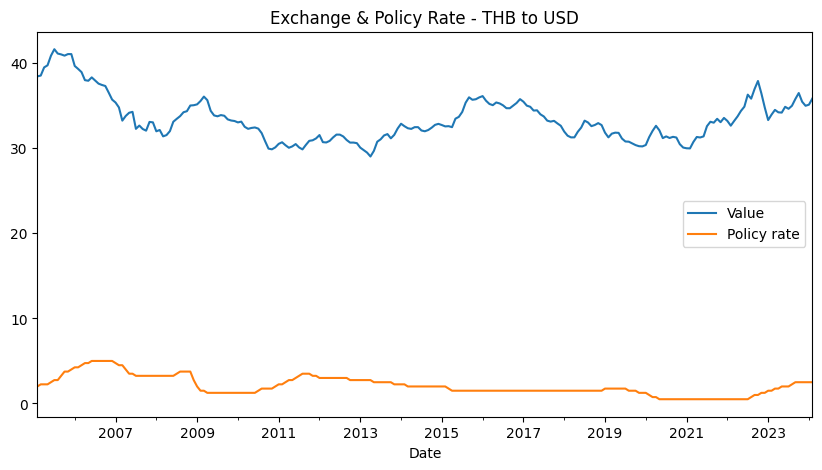

In [83]:
df.plot(figsize = (10,5)) #Plot Graph
plt.title('Exchange & Policy Rate - THB to USD')
plt.show()

Check Trend & Seasonal with hypothesis

In [84]:
Check_trend = mk.original_test(df['Value'])
print(Check_trend)

Mann_Kendall_Test(trend='decreasing', h=True, p=0.018188512392223632, z=-2.3617579709768495, Tau=-0.10488010419060752, s=-2738.0, var_s=1343008.6666666667, slope=-0.006712671156004477, intercept=33.73001723905724)


In [85]:
Check_Seasonal = kruskal(df['Policy rate'], df['Value'])
print(Check_Seasonal)

KruskalResult(statistic=343.45366739720055, pvalue=1.1291049072666409e-76)


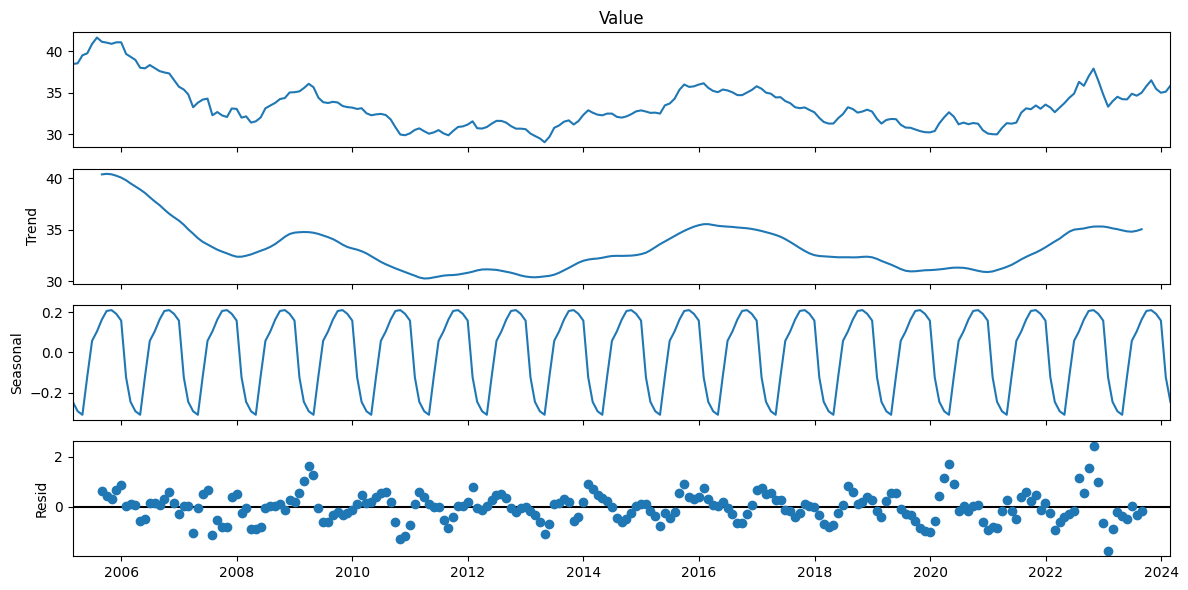

In [86]:
plt.rcParams['figure.figsize'] = (12,6)
decomposition = seasonal_decompose(df.Value, period = 12, model = 'additive')
decomposition.plot()
plt.show()

Check Stationary with hypothesis

In [87]:
def adf_check(time_series):
    result = adfuller(time_series , autolag = 'AIC')
    label = pd.Series(result[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in result[4].items():
        label['Critical Value (%s)'%key] = value
    print(label)
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis, hence REJECT null hypothesis and the series is Stationary')
    else:
        print ('Weak evidence against the null hypothesis, hence ACCEPT null hypothesis and the series is Not Stationary ')

In [88]:
adf_check(df['Value'])

Test Statistic                  -2.589813
p-value                          0.095121
Number of Lags Used              2.000000
Number of Observations Used    226.000000
Critical Value (1%)             -3.459620
Critical Value (5%)             -2.874415
Critical Value (10%)            -2.573632
dtype: float64
Weak evidence against the null hypothesis, hence ACCEPT null hypothesis and the series is Not Stationary 


In [89]:
df1 = df.diff().dropna()
print('Count of value', df1.shape[0])
df1.head()

Count of value 228


,Value,Policy rate
Date,,
2005-03-31,0.097022,0.25
2005-04-30,0.959431,0.00
2005-05-31,0.246093,0.00
2005-06-30,1.124773,0.25
2005-07-31,0.766658,0.25


In [90]:
adf_check(df1.Value)

Test Statistic                -1.004295e+01
p-value                        1.479677e-17
Number of Lags Used            1.000000e+00
Number of Observations Used    2.260000e+02
Critical Value (1%)           -3.459620e+00
Critical Value (5%)           -2.874415e+00
Critical Value (10%)          -2.573632e+00
dtype: float64
Strong evidence against the null hypothesis, hence REJECT null hypothesis and the series is Stationary


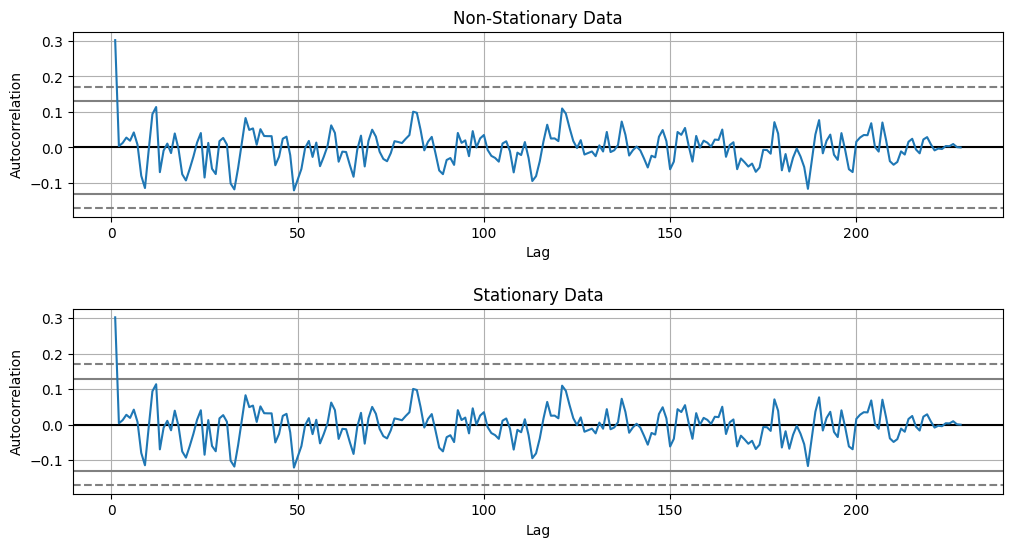

In [91]:
fig, (ax1,ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (12,6))
ax1 = autocorrelation_plot(df1, ax = ax1)
ax1.set_title('Non-Stationary Data')
ax2 = autocorrelation_plot(df1 , ax = ax2)
ax2.set_title('Stationary Data')
plt.subplots_adjust(hspace = 0.5)
plt.show()

Fitting Model

In [92]:
model_arimax = auto_arima(df['Value'], 
                          exog = df['Policy rate'], 
                          m = 12, 
                          d = 1, 
                          seasonal = False, 
                          max_order = 8,
                          test = 'adf', 
                          trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=358.647, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=374.116, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=356.010, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=352.793, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=372.216, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=354.760, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=354.756, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=356.724, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=350.848, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=352.818, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=352.814, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=354.052, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=354.785, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.015 seconds


In [93]:
model_arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  229
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -173.424
Date:                Tue, 16 Apr 2024   AIC                            350.848
Time:                        11:54:37   BIC                            357.707
Sample:                    02-28-2005   HQIC                           353.615
                         - 02-29-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3334      0.052      6.469      0.000       0.232       0.434
sigma2         0.2679      0.020     13.347      0.000       0.229       0.307
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                15.74
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                            -0.29
Prob(H) (two-sided):                  0.92   Kurtosis:                         4.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [95]:
print(model_arimax.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  229
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -173.424
Date:                Tue, 16 Apr 2024   AIC                            350.848
Time:                        11:55:16   BIC                            357.707
Sample:                    02-28-2005   HQIC                           353.615
                         - 02-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3334      0.052      6.469      0.000       0.232       0.434
sigma2         0.2679      0.020     13.347      0.000       0.229       0.307
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [ ]:
model_arimax1 = SARIMAX(df['Value'], 
                        order = (0,1,1), 
                        seasonal_order = (0,0,0,0), 
                        exog = df['Policy rate'], 
                        freq = 'M', 
                        enforce_stationarity = False, 
                        enforce_invertibility = False)
result = model_arimax1.fit(disp = False)

In [ ]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                  229
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -170.870
Date:                Tue, 16 Apr 2024   AIC                            347.740
Time:                        09:17:33   BIC                            358.002
Sample:                    02-28-2005   HQIC                           351.881
                         - 02-29-2024                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Policy rate    -0.1951      0.208     -0.937      0.349      -0.603       0.213
ma.L1           0.3334      0.052      6.472      0.000       0.232       0.434
sigma2          0.2656      0.020     13.384      0.000       0.227       0.304
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                17.48
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                            -0.29
Prob(H) (two-sided):                  0.91   Kurtosis:                         4.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
Ljingbox = sm.stats.acorr_ljungbox(result.resid, 
                                   lags = 5,
                                   return_df = True)
print(Ljingbox)

    lb_stat  lb_pvalue
1  0.003306   0.954152
2  0.132393   0.935947
3  0.132736   0.987638
4  0.344373   0.986773
5  0.374509   0.996003


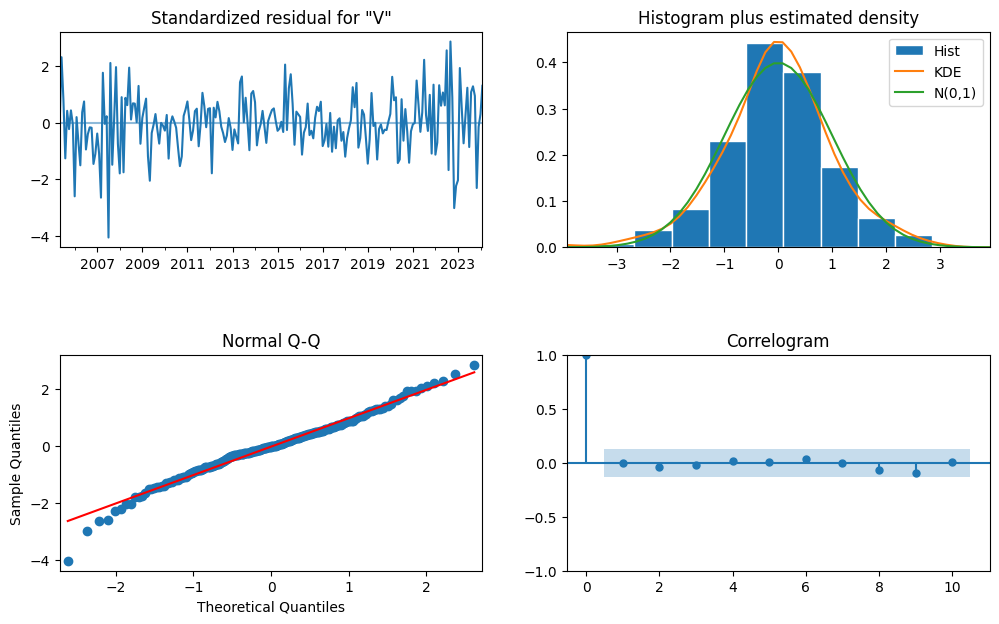

In [ ]:
result.plot_diagnostics(figsize = (12,7))
plt.subplots_adjust(hspace = 0.5)
plt.show()

In [ ]:
predictions = result.predict(typ = 'levels')

In [ ]:
print('Evaluation Result for whole data : ','\n')
print('R2 Score for whole data : {0:.2f} %'.format(100*r2_score(df['Value'],predictions)),'\n')
print('Mean Squared Error : ',mean_squared_error(df['Value'],predictions),'\n')
print('Mean Absolute Error : ',mean_absolute_error(df['Value'],predictions),'\n')
print('Root Mean Squared Error : ',sqrt(mean_squared_error(df['Value'],predictions)),'\n')
print('Mean Absolute Percentage Error : {0:.2f} %'.format(100*mean_absolute_percentage_error(df['Value'],predictions)))

Evaluation Result for whole data :  

R2 Score for whole data : 0.42 % 

Mean Squared Error :  6.857023250097682 

Mean Absolute Error :  0.5555376446691889 

Root Mean Squared Error :  2.6185918448848957 

Mean Absolute Percentage Error : 1.59 %


In [ ]:
Final = pd.concat([df, df1, predictions], axis = 1)
Final.columns = ['Foreign Exchange Rate (monthly)',
                      'Policr Rate (monthly)',
                      'Monthly First Difference',
                      'Predicted Policy Rate',
                      'Predicted Exchange Rate']
Final.head()

,Foreign Exchange Rate (monthly),Policr Rate (monthly),Monthly First Difference,Predicted Policy Rate,Predicted Exchange Rate
2005-02-28,38.459500,2.00,NaN,NaN,-0.390105
2005-03-31,38.556522,2.25,0.097022,0.25,38.410737
2005-04-30,39.515952,2.25,0.959431,0.00,38.556522
2005-05-31,39.762045,2.25,0.246093,0.00,39.803826
2005-06-30,40.886818,2.50,1.124773,0.25,39.699506


Walk forward Optimization

In [ ]:
train_size = 36  # Size of the training data
test_size = 3  # Size of the test data

In [ ]:
def walk_forward_optimization(df, train_size, test_size, start_month, last_model=None, in_sample_errors=None, out_of_sample_errors=None):
  if in_sample_errors is None:
      in_sample_errors = []
  if out_of_sample_errors is None:
      out_of_sample_errors = []

  predictions = []
  mse_values = []
  actual_values = []
  in_sample_statistic = []
  out_of_sample_statistic = []
  current_month = start_month
  model_fit = None

  for end_month in range(start_month + train_size, len(df) - test_size + 1):
    # Slice training data
    value_data = df['Value'].iloc[start_month - 1:end_month]
    policy_rate_data = df['Policy rate'].iloc[start_month - 1:end_month]
    
    # train_data is used to fit the ARIMA model
    train_data = np.stack((value_data.values, policy_rate_data.values), axis=1)

    # Fit ARIMA model
    model = ARIMA(train_data[:, 0], exog=train_data[:, 1].reshape(-1, 1), order=(0, 1, 1))
    model_fit = model.fit()

    # Predict only 1 step ahead (test_size)
    dummy_exog = np.zeros((3, 1))
    dummy_exog[0, 0] = df['Policy rate'].iloc[[end_month]].values[0]
    next_month_policy_rate = dummy_exog
    test_prediction = model_fit.forecast(steps=test_size, exog=next_month_policy_rate)[0]

    # Calculate MSE using actual value at next time step
    actual_value = df['Value'].iloc[end_month]
    mse_values.append(mean_squared_error([actual_value], [test_prediction]))

    # Calculate In-Sample Statistic
    in_sample_stat = model_fit.aic
    in_sample_statistic.append(in_sample_stat)

    # Calculate Out-of-Sample Statistic
    # Calculate Out-of-Sample Statistic when enough data is available
    if len(actual_values) >= test_size:
      out_of_sample_stat = mean_squared_error(actual_values[-test_size:], predictions[-test_size:])
      out_of_sample_statistic.append(out_of_sample_stat)

    # คำนวณค่าความผิดพลาดในชุดฝึก
    in_sample_errors.append(mean_squared_error(train_data[:, 0], model_fit.fittedvalues))

    # คำนวณค่าความผิดพลาดในชุดทดสอบ
    out_of_sample_errors.append(mse_values[-1])
    
    predictions.append(test_prediction)
    actual_values.append(actual_value)

    # Increase current month
    current_month += 1
  # Create DataFrame to store errors
  errors_df = pd.DataFrame({
      'In-Sample Errors': in_sample_errors,
      'Out-of-Sample Errors': out_of_sample_errors
    })
  
  return predictions, mse_values, actual_values, in_sample_statistic, out_of_sample_statistic, errors_df, model_fit

In [ ]:
forecast_months = 3
start_month = train_size + 1
rmse_values_all = []
predictions_all = []
actual_values_all = []
in_sample_statistic_all = []
out_of_sample_statistic_all = []
in_sample_errors_all = []
out_of_sample_errors_all = []
errors_df_list = []
last_model = None

# Loop until end of data
while start_month <= len(df) - forecast_months:
  # Run walk-forward optimization
  predictions, mse_values, actual_values, in_sample_statistic, out_of_sample_statistic, errors_df, last_model = walk_forward_optimization(
    df, train_size, test_size, start_month, last_model, in_sample_errors_all, out_of_sample_errors_all
)

  # Calculate WFE only when both in-sample and out-of-sample statistics are available
  if len(in_sample_statistic) == len(out_of_sample_statistic) and len(in_sample_statistic) > 0:
    # Calculate WFE
    wfe_values = [out / ins for out, ins in zip(out_of_sample_statistic, in_sample_statistic)]
    mean_wfe = np.mean(wfe_values)

  # Process and analyze results (calculate RMSE, plot graphs, etc.)
  rmse = np.sqrt(np.mean(mse_values))
  rmse_values_all.append(rmse)
  predictions_all.extend(predictions)  # Extend to keep all predictions
  actual_values_all.extend(actual_values)  # Extend to keep all actual values
  in_sample_statistic_all.extend(in_sample_statistic)  # Extend to keep all in-sample statistics
  out_of_sample_statistic_all.extend(out_of_sample_statistic)  # Extend to keep all out-of-sample statistics

  # Add errors_df to a list to keep all errors_df from each iteration
  errors_df_list.append(errors_df)

  # Update start month for next iteration
  start_month += 1

# Concatenate all errors_df in the list
errors_df = pd.concat(errors_df_list)

In [ ]:
# # แบ่งชุดข้อมูลออกเป็นชุดเทรนและชุดทดสอบ
# X_train, X_test, y_train, y_test = train_test_split(df['Value'], df['Policy rate'], test_size=0.3)

In [ ]:
# def walk_forward_optimization(X_train, y_train, X_test, y_test, train_size, test_size, start_month, last_model = None):
#   predictions = []
#   mse_values = []
#   actual_values = []
#   current_month = start_month
#   model_fit = None

#   for end_month in range(start_month + train_size, len(X_test) - test_size + 1):
#     # Slice training data
#     value_data = y_train.iloc[start_month - 1:end_month]
#     policy_rate_data = X_train.iloc[start_month - 1:end_month]

#     # train_data is used to fit the ARIMA model
#     train_data = np.stack((value_data.values, policy_rate_data.values), axis=1)

#     # Fit ARIMA model
#     model = ARIMA(train_data[:, 0], exog=train_data[:, 1], order=(0, 1, 1))
#     model_fit = model.fit()

#     # Predict only 1 step ahead (test_size)
#     next_month_policy_rate = X_test.iloc[[end_month]].values
#     test_prediction = model_fit.forecast(steps=test_size, exog=next_month_policy_rate)[0]

#     # Calculate MSE using actual value at next time step
#     actual_value = y_test.iloc[end_month]
#     mse_values.append(mean_squared_error([actual_value], [test_prediction]))

#     predictions.append(test_prediction)
#     actual_values.append(actual_value)

#     # Increase current month
#     current_month += 1

#   return predictions, mse_values, actual_values, current_month, model_fit

In [ ]:
# forecast_months = 3
# start_month = 1
# rmse_values_all = []
# predictions_all = []
# actual_values_all = []
# last_model = None

# while start_month <= len(df) - forecast_months:
#     # Running walk-forward optimization
#     predictions, mse_values, actual_values, current_month, last_model = walk_forward_optimization(
#         X_train, y_train, X_test, y_test, train_size, test_size, start_month, last_model
#     )

#     rmse = np.sqrt(np.mean(mse_values))
#     rmse_values_all.append(rmse)
#     predictions_all.extend(predictions)  # Extending to keep all predictions
#     actual_values_all.extend(actual_values)  # Extending to keep all actual values

#     start_month += 1

In [ ]:
print('Printing Predictied vs Expected Values....')
print('\n')

for predicted, actual in zip(predictions_all, actual_values_all):
    print('Predicted = %f , Actual = %f' % (predicted, actual))

Printing Predictied vs Expected Values....


Predicted = 30.743012 , Actual = 30.365217
Predicted = 30.162666 , Actual = 30.067619
Predicted = 30.003298 , Actual = 30.227727
Predicted = 30.418959 , Actual = 30.500682
Predicted = 30.594890 , Actual = 30.105952
Predicted = 29.804429 , Actual = 29.875348
Predicted = 29.921982 , Actual = 30.402500
Predicted = 30.742446 , Actual = 30.882286
Predicted = 30.946659 , Actual = 30.946682
Predicted = 30.946757 , Actual = 31.167273
Predicted = 31.284965 , Actual = 31.559955
Predicted = 31.753797 , Actual = 30.726571
Predicted = 30.020482 , Actual = 30.689591
Predicted = 30.983178 , Actual = 30.874000
Predicted = 30.822972 , Actual = 31.281913
Predicted = 31.510121 , Actual = 31.614762
Predicted = 31.666878 , Actual = 31.610455
Predicted = 31.580778 , Actual = 31.395217
Predicted = 31.296982 , Actual = 30.978500
Predicted = 30.826964 , Actual = 30.674783
Predicted = 30.595040 , Actual = 30.677727
Predicted = 30.722091 , Actual = 30.610476
Predicted

In [ ]:
print('Evaluation Result for Test data : ','\n')
print('R2 Score for Test data: {0:.2f} %'.format(100*r2_score(actual_values_all, predictions_all)),'\n')
print('Mean Squared Error: ', mean_squared_error(actual_values_all, predictions_all),'\n')
print('Mean Absolute Error: ', mean_absolute_error(actual_values_all, predictions_all),'\n')
print('Root Mean Squared Error: ', sqrt(mean_squared_error(actual_values_all, predictions_all)),'\n')
print('Mean Absolute Percentage Error: {0:.2f} %'.format(100*mean_absolute_percentage_error(actual_values_all, predictions_all)),'\n')

Evaluation Result for Test data :  

R2 Score for Test data: 91.28 % 

Mean Squared Error:  0.31981549686646377 

Mean Absolute Error:  0.4382011016807387 

Root Mean Squared Error:  0.5655223221646196 

Mean Absolute Percentage Error: 1.30 % 



In [ ]:
WFE = (sum(out_of_sample_statistic_all) / sum(in_sample_statistic_all))
print(WFE)

0.003305107057083336


In [ ]:
print(errors_df)

       In-Sample Errors  Out-of-Sample Errors
0             26.949449              0.142729
1             26.507019              0.009034
2             25.833705              0.050369
3             25.212140              0.006679
4             24.528980              0.239060
...                 ...                   ...
11930         27.232612              1.427841
11931         26.593233              0.000114
11932         27.838967              1.430214
11933         27.167731              0.000260
11934         26.533823              0.000057

[1658965 rows x 2 columns]


In [ ]:
print(sum(errors_df['In-Sample Errors']))
print(sum(errors_df['Out-of-Sample Errors']))

24311567.94135111
489931.44723170006


In [ ]:
mean_in_sample_error = errors_df['In-Sample Errors'].mean()
mean_out_of_sample_error = errors_df['Out-of-Sample Errors'].mean()

In [ ]:
print(mean_in_sample_error)
print(mean_out_of_sample_error)

14.65465994843184
0.29532355850288244


In [ ]:
print(mean_out_of_sample_error / mean_in_sample_error)

0.02015219456078094


In [ ]:
WFE2 = (sum(errors_df['Out-of-Sample Errors']) / sum(errors_df['In-Sample Errors']))
print(WFE2)

0.0201521945607788
